In [33]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from sympy.logic import SOPform, boolalg
from sympy import symbols, srepr, Not
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from BoolFuncModule.BoolFunc import BoolFunc
import BoolFuncModule.ParameterAssignment as PA
import BoolFuncModule.NNfunctions as NNf
import BoolFuncModule.RobustnessFunctions as RF

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
testFunc = BoolFunc(parameterType=1)

print(testFunc.get_parameters())
print(testFunc.get_SOP())
print(testFunc.get_D())
print(testFunc.forward(np.array([[1], [1], [1]])))
print(testFunc.get_truth_table())
print(testFunc.get_robustness())

(array([[ 0,  1,  0],
       [ 0, -1,  1],
       [ 1, -1, -1],
       [ 0, -1,  1]]), array([[0],
       [0],
       [0],
       [0]]), array([[ 1,  0,  1, -1]]), 0)
0 | 1 | 2
4
[[1]]
00111011
0.53125


In [70]:
sampleSize = 10000
parameterType = 1
n = 3

df = pd.DataFrame({'Frequency': [], 'Dimension': [], 'Robustness': []})
for i in tqdm(range(sampleSize)):
    function = BoolFunc(n=n, parameterType=parameterType)
    isInIndex = False
    truthTable = function.get_truth_table()
    if truthTable in df.index:
        isInIndex = True
        df.at[truthTable, 'Frequency'] += 1
        df.at[truthTable, 'Robustness'] = ((df.at[truthTable, 'Frequency']-1)*df.at[truthTable, 'Robustness'] + function.get_robustness())/df.at[truthTable, 'Frequency']
    if isInIndex is False:
        newRow = pd.DataFrame({'Frequency': 1, 'Dimension': function.get_D(), 'Robustness': function.get_robustness()}, index=[truthTable])
        df = pd.concat([df, newRow], axis=0)

df.to_csv(f'type{parameterType}/samples{sampleSize}.csv')

100%|██████████| 10000/10000 [00:52<00:00, 189.38it/s]


In [94]:
sampleSize = 100000
parameterType = 1
n = 4
numberOfFunctions = 2**(2**n)
numberOfLookUpFiles = 128  # Must be an exponent of 2
fileLength = int(numberOfFunctions / numberOfLookUpFiles)


df = pd.DataFrame({'Frequency': [], 'Dimension': [], 'Robustness': []})
for i in tqdm(range(sampleSize)):
    function = BoolFunc(n=n, parameterType=parameterType, bool_update_D=False) # Seeting to False since we are using look up tables for the dimension
    isInIndex = False
    truthTable = function.get_truth_table()
    if truthTable in df.index:
        isInIndex = True
        df.at[truthTable, 'Frequency'] += 1
        df.at[truthTable, 'Robustness'] = ((df.at[truthTable, 'Frequency']-1)*df.at[truthTable, 'Robustness'] + function.get_robustness())/df.at[truthTable, 'Frequency']
    if isInIndex is False:
        lookUpFileNumber = int(truthTable, 2) // fileLength
        LUTable = pd.read_csv(f'LookUpTables/n{n}/file{lookUpFileNumber}.csv', dtype={0 : 'str'}).set_index('Unnamed: 0')
        newRow = pd.DataFrame({'Frequency': 1, 'Dimension': LUTable.at[truthTable, 'Dimension'], 'Robustness': function.get_robustness()}, index=[truthTable])
        df = pd.concat([df, newRow], axis=0)
        
df.to_csv(f'n{n}/type{parameterType}/samples{sampleSize}.csv')


100%|██████████| 100000/100000 [37:52<00:00, 44.00it/s] 


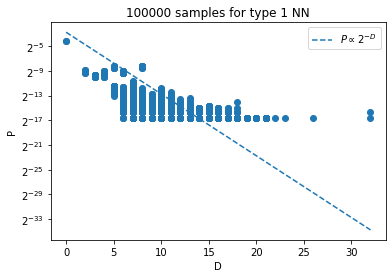

In [95]:
df_plot = pd.read_csv(f'n{n}/type{parameterType}/samples{sampleSize}.csv', index_col=0)
#df_plot = pd.read_csv('type4/samples100000.csv', index_col=0)
P = df_plot['Frequency']/sampleSize
D = df_plot['Dimension']
R = df_plot['Robustness']

x = np.linspace(0, max(D), 100)
y = 0.15*2**(-x)

plt.scatter(D, P)
plt.plot(x,y, linestyle='--', label='$P\propto2^{-D}$')
plt.yscale('log', base=2)
plt.title(f'{sampleSize} samples for type {parameterType} NN')
plt.xlabel('D')
plt.ylabel('P')
plt.legend()
plt.savefig(f'n{n}/type{parameterType}/P_vs_D_samples{sampleSize}.png')
plt.show()

In [96]:
k = 3
if parameterType in {0,1,2,3}:
    l = (n+1)*(2**(n-1))
elif parameterType in {4}:
    l = (n+2)*(2**(n-1))
else:
    raise Exception('ParameterType not valid')

logF_cont = pd.read_csv('RobustnessCurves/k'+str(k)+'_l'+str(l)+'/logF_continuous.txt', header=None)
rho_blancmange = pd.read_csv('RobustnessCurves/k'+str(k)+'_l'+str(l)+'/rho_blancmange.txt', header=None)
rho_1comp_min = pd.read_csv('RobustnessCurves/k'+str(k)+'_l'+str(l)+'/rho_1comp_min.txt', header=None)
rho_lower = pd.read_csv('RobustnessCurves/k'+str(k)+'_l'+str(l)+'/rho_lower.txt', header=None)
rho_upper = pd.read_csv('RobustnessCurves/k'+str(k)+'_l'+str(l)+'/rho_upper.txt', header=None)
rho_null = pd.read_csv('RobustnessCurves/k'+str(k)+'_l'+str(l)+'/rho_null.txt', header=None)

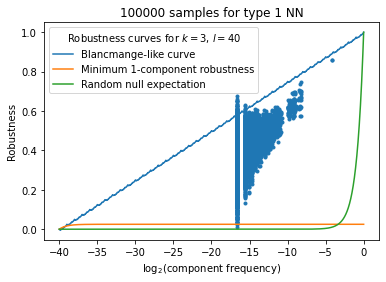

In [97]:
plt.scatter(np.log2(P), R, marker='.')
plt.plot(logF_cont, rho_blancmange, label='Blancmange-like curve')
plt.plot(logF_cont, rho_1comp_min, label='Minimum 1-component robustness')
plt.plot(logF_cont, rho_null, label='Random null expectation')
plt.title(f'{sampleSize} samples for type {parameterType} NN')
plt.xlabel('log$_2$(component frequency)')
plt.ylabel('Robustness')
plt.legend(title=f'Robustness curves for $k=${k}, $l=${l}')
plt.savefig(f'n{n}/type{parameterType}/R_vs_logP_samples{sampleSize}.png')
plt.show()


In [46]:
a = [*np.base_repr(4,base=3)]
a

['1', '1']

In [50]:
print(int('2', 2))

ValueError: invalid literal for int() with base 2: '2'

In [25]:
if 1/1:
    print('yes')

yes


In [3]:
RF.biternary(3**12 * 2**4 -4, 4, 12)

'1111222222222212'

100%|██████████| 8503055/8503055 [03:51<00:00, 36662.08it/s]


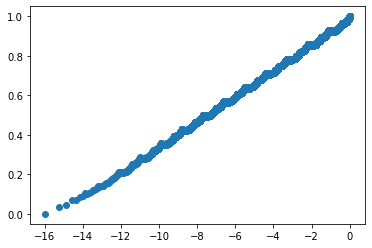

In [3]:
F = np.arange(3**12 * 2**4) + 1
Sk = np.zeros((3**12 * 2**4))
Sk[0] = 0
for i in tqdm(np.arange(1,3**12 * 2**4)):
    temp = [*RF.terbinary(i)]
    Sk[i] = Sk[i-1] + np.sum([int(j) for j in temp])
logF_all = np.log(F/(3**12 * 2**4))
rhobg_all = 2*np.divide(Sk,F)/(12*(3-1) + 4*(2-1))

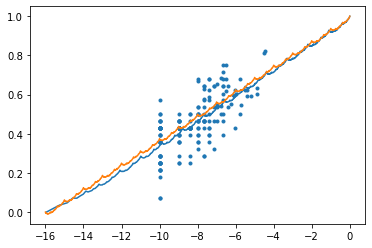

In [11]:
plt.plot(logF_all, rhobg_all)
plt.scatter(np.log2(P), R, marker='.')
plt.plot(logF_cont, rho_blancmange, label='Blancmange-like curve')